In [ ]:
#Abnormality Prediction base
!pip install -q --upgrade keras-hub
!pip install -q --upgrade keras  # Upgrade to Keras 3.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import os

#os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
#from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub

# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
def plot_image_gallery(images, titles=None, num_cols=3, figsize=(6, 12)):
    num_images = len(images)
    print(num_images)
    images = np.asarray(images) / 255.0
    images = np.minimum(np.maximum(images, 0.0), 1.0)
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()  # Flatten in case the axes is a 2D array

    for i, ax in enumerate(axes):
        if i < num_images:
            # Plot the image
            ax.imshow(images[i])
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=12)
        else:
            # Turn off the axis for any empty subplot
            ax.axis("off")

    plt.show()
    plt.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_DIR_IMG = '/content/drive/MyDrive/CS230_Project/Dental_DB/Classify/Data/'
BATCH_SIZE = 4
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()
train_ds = tf.keras.utils.image_dataset_from_directory(DATASET_DIR_IMG, validation_split=0.1, subset="training", seed=42, image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),  batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(DATASET_DIR_IMG, validation_split=0.1, subset="validation", seed=42, image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),  batch_size=BATCH_SIZE)
class_names = train_ds.class_names
print(class_names)


Found 1000 files belonging to 2 classes.
Using 900 files for training.
Found 1000 files belonging to 2 classes.
Using 100 files for validation.
['Abnormal', 'Normal']


In [ ]:
num_classes = len(train_ds.class_names)
print(num_classes)

resizing = keras.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    # Staticly resize images as we only iterate the dataset once.
    return image, tf.one_hot(label, num_classes)

train_ds = train_ds.map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
#train_ds = train_ds.batch(BATCH_SIZE)



2


32


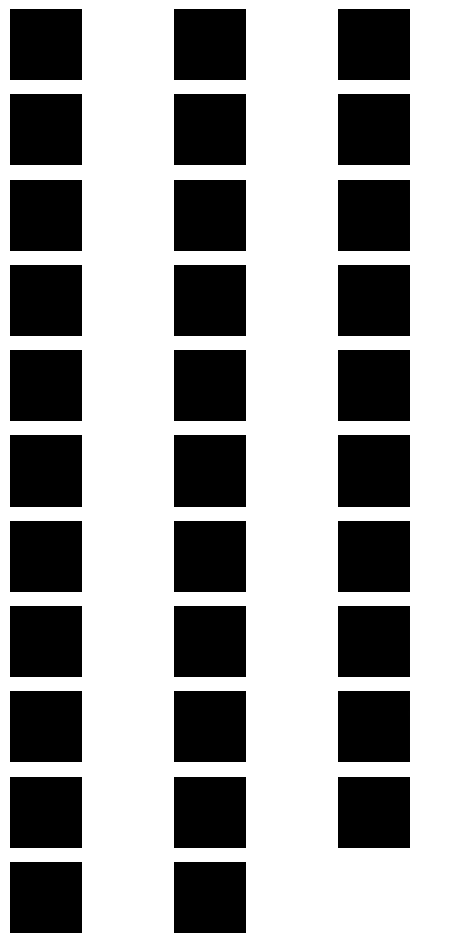

In [ ]:
images = next(iter(train_ds.take(1)))[0]
plot_image_gallery(images)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 2)


In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 2)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = keras_hub.models.ImageClassifier.from_preset(
    "resnet_18_imagenet", num_classes=2
)
image_features = tf.keras.layers.GlobalAveragePooling2D()(model)
image_input = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), name='image')

image_features = tf.keras.layers.Dense(256, activation="relu")(image_features)
image_features = tf.keras.layers.Dropout(0.3)(image_features)
image_features = tf.keras.layers.Dense(128, activation="relu")(image_features)
image_features = tf.keras.layers.Dropout(0.3)(image_features)
image_features = tf.keras.layers.Dense(64, activation="relu")(image_features)
image_features = tf.keras.layers.Dropout(0.3)(image_features)
output = tf.keras.layers.Dense(1, activation='sigmoid', name = "main_output")(image_features)
model = tf.keras.Model(inputs=image_input, outputs=output, name = "Image_Encoder")

100%|██████████| 836/836 [00:00<00:00, 1.03MB/s]


100%|██████████| 3.58k/3.58k [00:00<00:00, 4.10MB/s]


100%|██████████| 44.8M/44.8M [00:01<00:00, 29.9MB/s]


100%|██████████| 42.8M/42.8M [00:01<00:00, 39.1MB/s]


ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <ResNetImageClassifier name=res_net_image_classifier, built=True> (of type <class 'keras_hub.src.models.resnet.resnet_image_classifier.ResNetImageClassifier'>)

In [ ]:
image_input = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), name='image')
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False)(image_input)
image_features = tf.keras.layers.GlobalAveragePooling2D()(base_model)


image_features = tf.keras.layers.Dense(256, activation="relu")(image_features)
image_features = tf.keras.layers.Dropout(0.3)(image_features)
image_features = tf.keras.layers.Dense(128, activation="relu")(image_features)
image_features = tf.keras.layers.Dropout(0.3)(image_features)
image_features = tf.keras.layers.Dense(64, activation="relu")(image_features)
image_features = tf.keras.layers.Dropout(0.3)(image_features)
output = tf.keras.layers.Dense(2, activation='softmax', name = "main_output")(image_features)
model = tf.keras.Model(inputs=image_input, outputs=output, name = "Image_Encoder")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def resnet18_with_regularization(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes=2, weight_decay=0.75):
    inputs = tf.keras.Input(shape=input_shape)
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights=None,
        input_tensor=inputs,
        pooling=None
    )

    # Apply L2 regularization to each trainable layer in ResNet
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            layer.kernel_regularizer = tf.keras.regularizers.l2(weight_decay)

    # Add custom classification head
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = resnet18_with_regularization()

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy", tf.keras.metrics.F1Score()],
)

In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.5636 - f1_score: 0.4737 - loss: 259.7121 - val_accuracy: 0.3500 - val_f1_score: 0.2593 - val_loss: 95.8849
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5852 - f1_score: 0.5100 - loss: 70.4585 - val_accuracy: 0.6500 - val_f1_score: 0.3939 - val_loss: 23.7077
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6012 - f1_score: 0.5088 - loss: 17.1460 - val_accuracy: 0.6500 - val_f1_score: 0.3939 - val_loss: 5.6395
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6372 - f1_score: 0.5123 - loss: 4.1126 - val_accuracy: 0.6500 - val_f1_score: 0.3939 - val_loss: 1.8174
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6241 - f1_score: 0.4951 - loss: 1.3659 - val_accuracy: 0.6500 - val_f1_score: 0.3939 - val_loss: 0.9609
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6454 - f1_score: 0.5035 - loss: 0.7693 - val_accuracy: 0.6500 - val_f1_

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
print(model.summary())

Preprocessor: "res_net_image_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ res_net_image_converter (ResNetImageConverter)                │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "res_net_image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)                   │ (None, None, None, 3)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ res_net_backbone (ResNetBackbone)             │ (None, None, None, 512)            │          11,186,112 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ pooler (GlobalAveragePooling2D)               │ (None, 512)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 512)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 2)                          │               1,026 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 33,542,216 (127.95 MB)

 Trainable params: 11,177,538 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 22,355,078 (85.28 MB)

None
